<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Statistics (2)

Dr. Yves J. Hilpisch

The Python Quants GmbH

<a href='http://fpq.io'>http://fpq.io</a> | <a href='mailto:team@tpq.io'>team@tpq.io</a>

## Principal Component Analysis

In [4]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from pandas_datareader import data as web
from sklearn.decomposition import KernelPCA

### DAX Index and its 30 Stocks

In [5]:
symbols = ['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE',
           'BMW.DE', 'CBK.DE', 'CON.DE', 'DAI.DE', 'DB1.DE',
           'DBK.DE', 'DPW.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE',
           'FRE.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'LHA.DE',
           'LIN.DE', 'LXS.DE', 'MRK.DE', 'MUV2.DE', 'RWE.DE',
           'SAP.DE', 'SDF.DE', 'SIE.DE', 'TKA.DE', 'VOW3.DE',
           '^GDAXI']

In [6]:
%%time
try:
    h5 = pd.HDFStore('dax.h5')
    data = h5['dax']
    h5.close
except:
    data = pd.DataFrame()
    for sym in symbols:
        data[sym] = web.DataReader(sym, data_source='yahoo')['Close']
    data = data.dropna()
    h5 = pd.HDFStore('dax.h5')
    h5['dax'] = data
    h5.close

ImportError: HDFStore requires PyTables, "No module named 'tables'" problem importing

In [7]:
dax = pd.DataFrame(data.pop('^GDAXI'))

In [8]:
data[data.columns[:6]].head()

,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE
Date,,,,,,
2010-01-04,38.505,88.54,44.850,56.40,46.445,32.050
2010-01-05,39.720,88.81,44.170,55.37,46.200,32.310
2010-01-06,39.400,89.50,44.450,55.02,46.165,32.810
2010-01-07,39.745,88.47,44.155,54.30,45.700,33.100
2010-01-08,39.600,87.99,44.020,53.82,44.380,32.655


### Applying PCA

In [9]:
scale_function = lambda x: (x - x.mean()) / x.std()

In [10]:
pca = KernelPCA().fit(data.apply(scale_function))

In [11]:
len(pca.lambdas_)

974

In [12]:
pca.lambdas_[:10].round()

array([ 35727.,   5947.,   5238.,   3309.,   2084.,    813.,    753.,
          533.,    312.,    227.])

In [13]:
get_we = lambda x: x / x.sum()

In [14]:
get_we(pca.lambdas_)[:10]

array([ 0.63924101,  0.10640311,  0.09371604,  0.05920043,  0.03728532,
        0.01455327,  0.01346867,  0.00954202,  0.00558883,  0.00405898])

In [15]:
get_we(pca.lambdas_)[:5].sum()

0.93584591618736812

### Constructing a PCA Index

In [16]:
pca = KernelPCA(n_components=1).fit(data.apply(scale_function))
dax['PCA_1'] = pca.transform(-data)

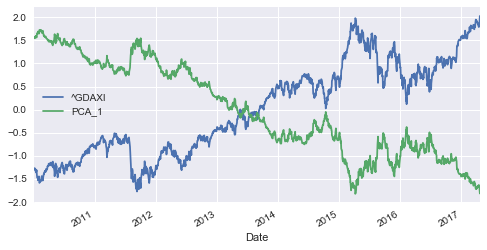

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
dax.apply(scale_function).plot(figsize=(8, 4))

In [18]:
pca = KernelPCA(n_components=5).fit(data.apply(scale_function))
pca_components = pca.transform(data)
weights = get_we(pca.lambdas_)
dax['PCA_5'] = np.dot(pca_components, weights)

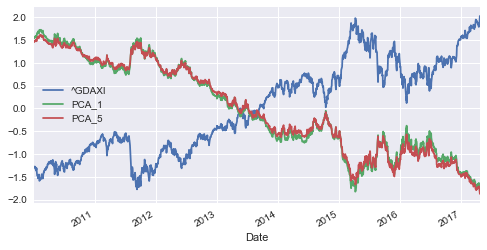

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
dax.apply(scale_function).plot(figsize=(8, 4))

In [20]:
import matplotlib as mpl
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())
mpl_dates

array([ 733776.,  733777.,  733778., ...,  736445.,  736446.,  736447.])

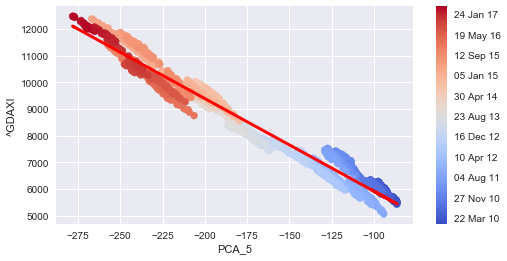

In [21]:
plt.figure(figsize=(8, 4))
plt.scatter(dax['PCA_5'], dax['^GDAXI'], c=mpl_dates, cmap=plt.cm.coolwarm)
lin_reg = np.polyval(np.polyfit(dax['PCA_5'],
                                dax['^GDAXI'], 1),
                                dax['PCA_5'])
plt.plot(dax['PCA_5'], lin_reg, 'r', lw=3)
plt.grid(True)
plt.xlabel('PCA_5')
plt.ylabel('^GDAXI')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
                format=mpl.dates.DateFormatter('%d %b %y'))

In [22]:
cut_date = '2011/7/1'
early_pca = dax[dax.index < cut_date]['PCA_5']
early_reg = np.polyval(np.polyfit(early_pca,
                dax['^GDAXI'][dax.index < cut_date], 1),
                early_pca)

In [23]:
late_pca = dax[dax.index >= cut_date]['PCA_5']
late_reg = np.polyval(np.polyfit(late_pca,
                dax['^GDAXI'][dax.index >= cut_date], 1),
                late_pca)

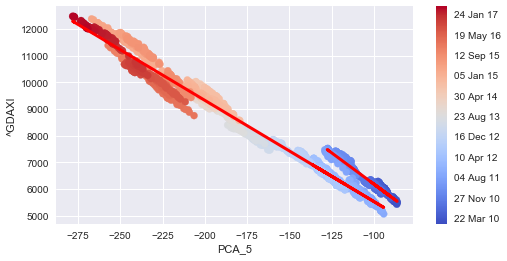

In [24]:
plt.figure(figsize=(8, 4))
plt.scatter(dax['PCA_5'], dax['^GDAXI'], c=mpl_dates, cmap=plt.cm.coolwarm)
plt.plot(early_pca, early_reg, 'r', lw=3)
plt.plot(late_pca, late_reg, 'r', lw=3)
plt.grid(True)
plt.xlabel('PCA_5')
plt.ylabel('^GDAXI')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
                format=mpl.dates.DateFormatter('%d %b %y'))

## Bayesian Regression &mdash; Basic Example (1)

In [25]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [26]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2

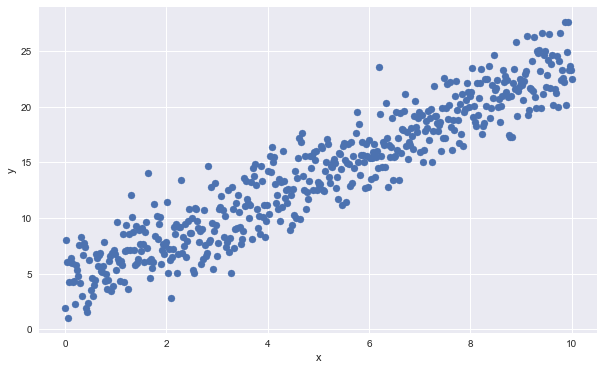

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, marker='o')
# plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y');

In [28]:
# linear regression
reg = np.polyfit(x, y, 1)

In [29]:
reg

array([ 1.99219622,  4.01244381])

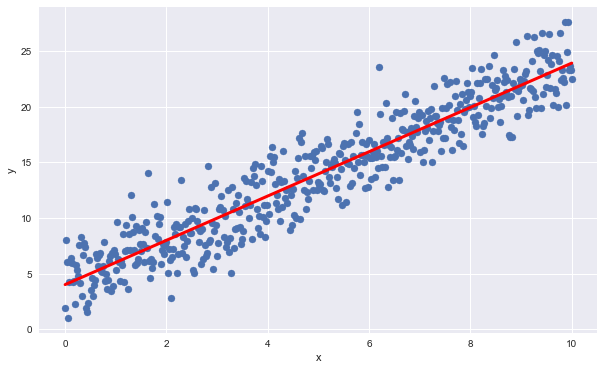

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, marker='o')
plt.plot(x, reg[1] + reg[0] * x, 'r', lw=3.0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y');

In [32]:
from pymc3 import Model, Normal, Uniform, HalfNormal

In [34]:
model = Model()
with model: 
        # model specifications in PyMC3
        # are wrapped in a with-statement
    # define priors
    alpha = Normal('alpha', mu=0, sd=20)
    beta = Normal('beta', mu=0, sd=20)
    sigma = HalfNormal('sigma', sd=1)
    
    # define linear regression
    y_est = alpha + beta * x
    
    # define likelihood
    y_obs = Normal('y', mu=y_est, sd=sigma, observed=y)

In [35]:
from pymc3 import find_MAP

In [41]:
map_estimate = find_MAP(model=model)

Optimization terminated successfully.
         Current function value: 1076.887523
         Iterations: 24
         Function evaluations: 36
         Gradient evaluations: 36


In [42]:
map_estimate

{'alpha': array(4.012135746012531),
 'beta': array(1.9922411424437736),
 'sigma_log_': array(0.7127812486213291)}

In [43]:
from pymc3 import NUTS, sample

In [46]:
# inference
with model: 
    start = find_MAP()
      # find starting value by optimization
    step = NUTS(state=start)
      # instantiate MCMC sampling algorithm
    trace = sample(250, step, start=start, progressbar=True)
      # draw 250 posterior samples using NUTS sampling

Optimization terminated successfully.
         Current function value: 1076.887523
         Iterations: 24
         Function evaluations: 36
         Gradient evaluations: 36


  0%|          | 0/250 [00:00<?, ?it/s]

  6%|▋         | 16/250 [00:00<00:01, 159.17it/s]

  8%|▊         | 21/250 [00:00<00:03, 68.81it/s] 

 12%|█▏        | 29/250 [00:00<00:03, 66.74it/s]

 16%|█▋        | 41/250 [00:00<00:02, 76.44it/s]

 20%|██        | 50/250 [00:00<00:02, 80.04it/s]

 23%|██▎       | 58/250 [00:00<00:03, 49.49it/s]

 27%|██▋       | 67/250 [00:01<00:03, 47.50it/s]

 32%|███▏      | 81/250 [00:01<00:03, 48.15it/s]

 36%|███▌      | 90/250 [00:01<00:02, 55.92it/s]

 39%|███▉      | 97/250 [00:01<00:02, 53.48it/s]

 42%|████▏     | 106/250 [00:01<00:02, 60.82it/s]

 45%|████▌     | 113/250 [00:01<00:02, 55.88it/s]

 48%|████▊     | 120/250 [00:02<00:02, 49.32it/s]

 58%|█████▊    | 146/250 [00:02<00:01, 64.69it/s]

 63%|██████▎   | 157/250 [00:02<00:01, 72.70it/s]

 72%|███████▏  | 179/250 [00:02<00:00, 90.82it/s]

 78%|███████▊  | 194/250 [00:02<00:00, 102.99it/s]

 84%|████████▍ | 210/250 [00:02<00:00, 115.18it/s]

 90%|█████████ | 225/250 [00:02<00:00, 113.37it/s]

 96%|█████████▌| 239/250 [00:02<00:00, 119.74it/s]

100%|██████████| 250/250 [00:02<00:00, 85.99it/s] 

In [52]:
trace[0]

{'alpha': 4.0066118207048298,
 'beta': 1.9884531901476179,
 'sigma': 2.0390291355534198,
 'sigma_log_': 0.71247378062873823}

In [49]:
trace[1]

{'alpha': 3.7695871225258264,
 'beta': 2.0336588456631599,
 'sigma': 1.9855543355745591,
 'sigma_log_': 0.68589813740689454}

In [53]:
from pymc3 import traceplot

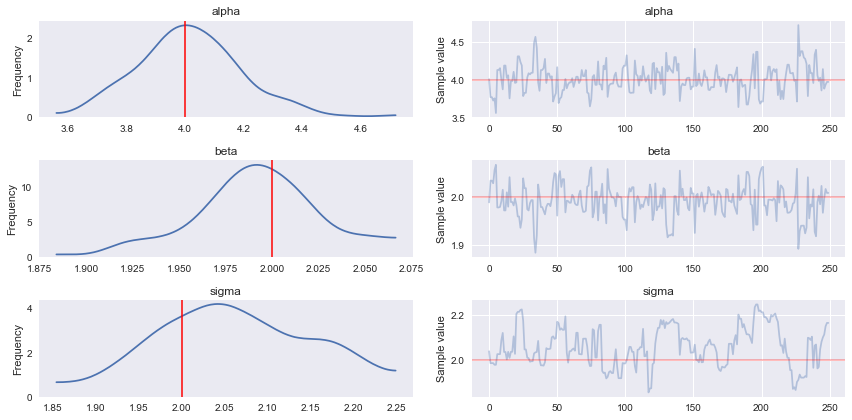

In [54]:
traceplot(trace, lines={'alpha': 4, 'beta': 2, 'sigma': 2});

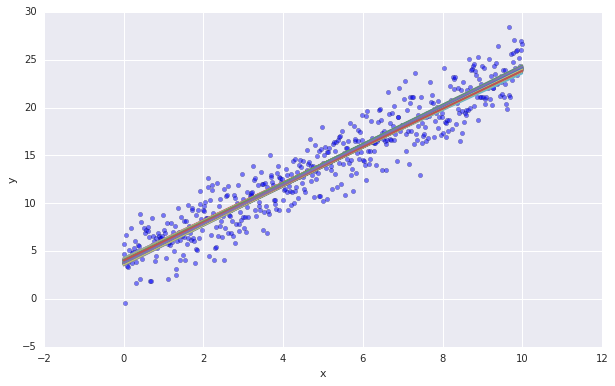

In [94]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, marker='o', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x)

(0, 10)

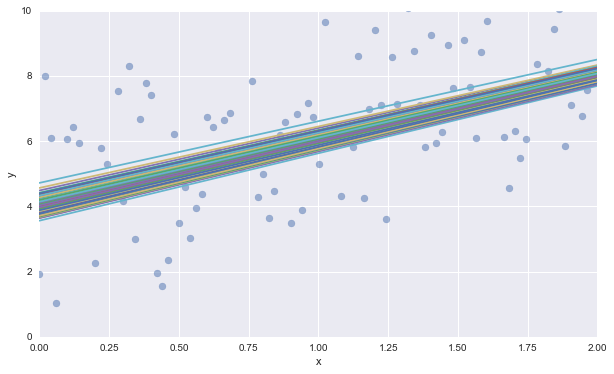

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, marker='o', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x)
plt.xlim(0, 2)
plt.ylim(0, 10)

## Bayesian Regression &mdash; Basic Example (2)

Cf. http://pymc-devs.github.io/pymc3/notebooks/getting_started.html

### The Data

In [41]:
# initialize random number generator
np.random.seed(123)

In [42]:
# true parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

In [43]:
# size of dataset
size = 100

In [44]:
# predictor variable
X1 = np.linspace(0, 1, size)
X2 = np.linspace(0, 0.2, size)

In [45]:
# simulate custom variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

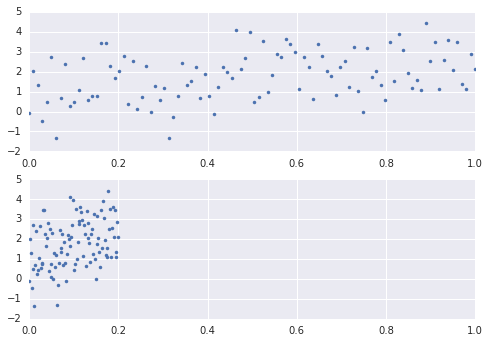

In [46]:
plt.subplot(211)
plt.plot(X1, Y, '.')
plt.subplot(212)
plt.plot(X2, Y, '.')
plt.xlim(0, 1);

### The Model

In [47]:
from pymc3 import Model, Normal, HalfNormal

In [48]:
basic_model = Model()

with basic_model:
    # priors of the unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)
    
    # expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Applied log-transform to sigma and added transformed sigma_log_ to model.


### Model Fitting

In [49]:
from pymc3 import find_MAP

In [50]:
%time map_estimate = find_MAP(model=basic_model)

CPU times: user 3.94 s, sys: 35.8 ms, total: 3.97 s
Wall time: 3.98 s


In [51]:
print(map_estimate)

{'alpha': array(1.013664091407883), 'beta': array([ 1.46791597,  0.29358319]), 'sigma_log_': array(0.1192876944997906)}


In [52]:
from scipy import optimize

In [53]:
%time map_estimate = find_MAP(model=basic_model, fmin=optimize.fmin_powell)

CPU times: user 97.1 ms, sys: 8.05 ms, total: 105 ms
Wall time: 101 ms


In [54]:
print(map_estimate)

{'alpha': array(1.0175522115056725), 'beta': array([ 1.51426781,  0.03520891]), 'sigma_log_': array(0.1181510683418693)}


### Sampling 

In [55]:
from pymc3 import NUTS, sample, trace

In [56]:
%%time
with basic_model:
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)
    
    # instantiate sampler
    step = NUTS(scaling=start)
    
    # draw 250 posterior samples
    trace = sample(250, step, start=start)

 [-----------------100%-----------------] 250 of 250 complete in 1.4 secCPU times: user 14.3 s, sys: 151 ms, total: 14.5 s
Wall time: 14.5 s


In [57]:
from pymc3 import traceplot

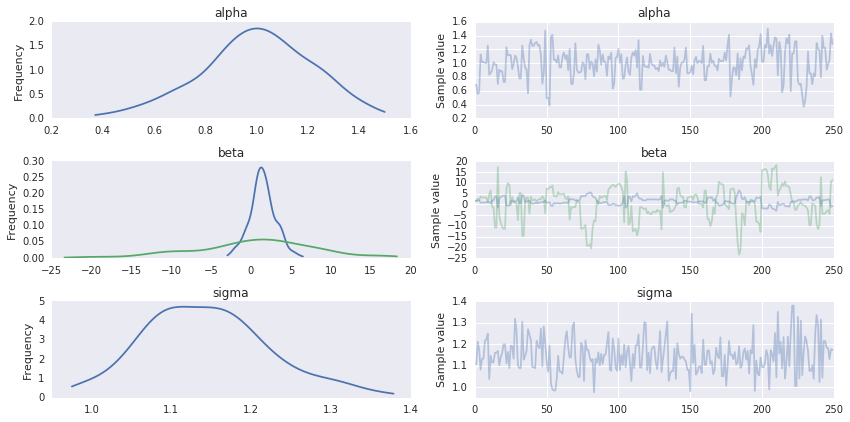

In [58]:
traceplot(trace);

### Summary

In [59]:
from pymc3 import summary

In [60]:
trace.varnames

['alpha', 'beta', 'sigma_log_', 'sigma']

In [55]:
summary(trace)

NameError: name 'summary' is not defined

## Bayesian Regression &mdash; Stochastic Volatility

In [62]:
from pandas_datareader import data as web

In [63]:
try:
    h5 = pd.HDFStore('spx.h5')
    data = h5['spx']
    h5.close
except:
    data = web.DataReader('^GSPC', data_source='yahoo',
                      start='2008-1-1', end='2009-12-31')
    h5 = pd.HDFStore('spx.h5')
    h5['spx'] = data
    h5.close

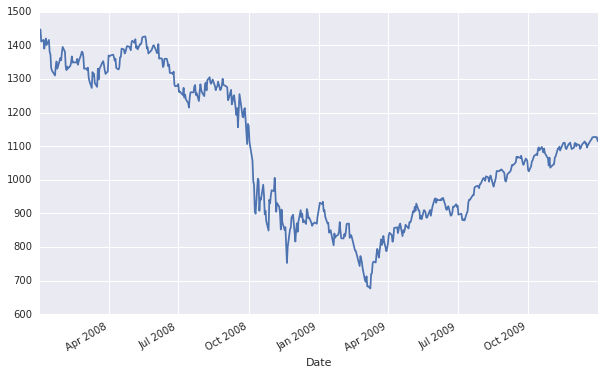

In [64]:
data['Close'].plot(figsize=(10, 6));

In [65]:
rets = np.log(data['Close'] / data['Close'].shift(1))

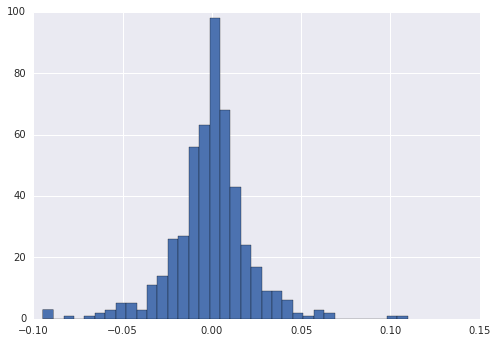

In [66]:
rets.hist(bins=35);

In [100]:
from pymc3 import Exponential, StudentT, exp, Deterministic

In [101]:
from pymc3.distributions.timeseries import GaussianRandomWalk

In [102]:
%%time
with Model() as sp500_model:
    nu = Exponential('nu', 1./10, testval=5.0)
    sigma = Exponential('sigma', 1./.02, testval=.1)
    s = GaussianRandomWalk('s', sigma**-2, shape=len(rets))
    volatility_process = Deterministic('volatility_process', exp(-2*s))
    r = StudentT('r', nu, lam=1/volatility_process, observed=rets)

Applied log-transform to nu and added transformed nu_log_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.
CPU times: user 220 ms, sys: 4 ms, total: 224 ms
Wall time: 222 ms


In [103]:
%%time
with sp500_model:
    start = find_MAP(vars=[s], fmin=optimize.fmin_l_bfgs_b)
    
    step = NUTS(scaling=start)
    trace = sample(100, step, progressbar=True)
    
    # start next run at the last sample's position
    step = NUTS(scaling=trace[-1], gamma=0.25)
    trace = sample(200, step, start=trace[-1], progressbar=True, njobs=1)

 [-----------------100%-----------------] 200 of 200 complete in 25.6 secCPU times: user 1min 49s, sys: 1.03 s, total: 1min 50s
Wall time: 1min 50s


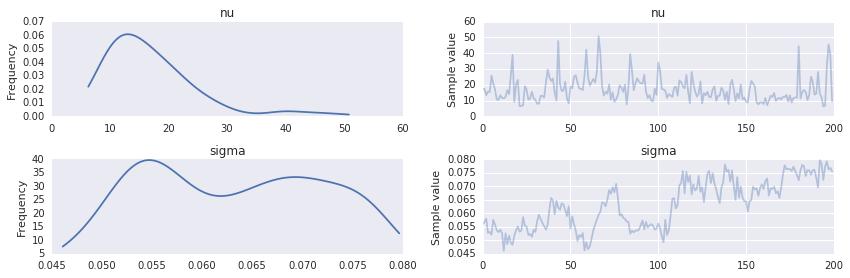

In [104]:
traceplot(trace, [nu, sigma]);

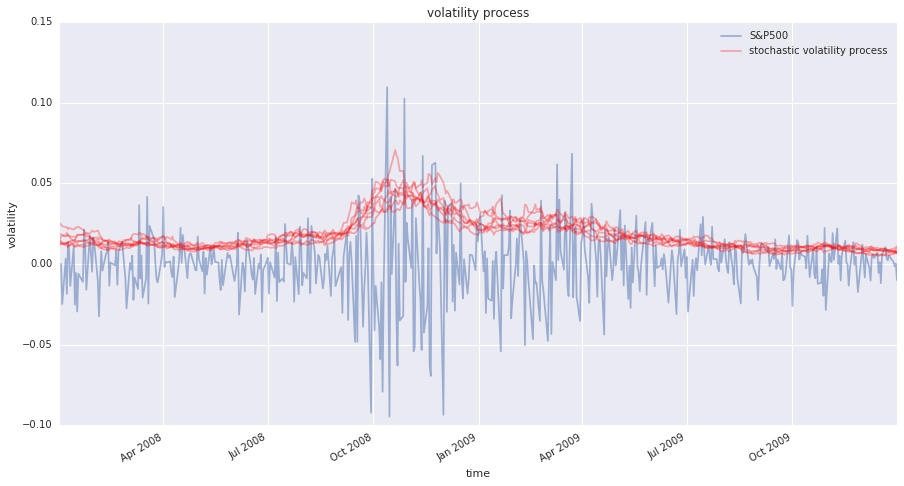

In [108]:
fig, ax = plt.subplots(figsize=(15, 8))
rets.plot(ax=ax, alpha=0.5)
ax.plot(rets.index, 1 / np.exp(trace['s', ::30].T), 'r', alpha=.3);
ax.set(title='volatility process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process']);

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="mailto:yves@tpq.io">yves@tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="http://hilpisch.com" target="_blank">http://hilpisch.com</a> 

**Quant Platform** &mdash; <a href="http://quant-platform.com" target="_blank">http://quant-platform.com</a>

**Python for Finance** &mdash; <a href="http://python-for-finance.com" target="_blank">http://python-for-finance.com</a>

**Derivatives Analytics with Python** &mdash; <a href="http://derivatives-analytics-with-python.com" target="_blank">http://derivatives-analytics-with-python.com</a>

**Python Trainings** &mdash; <a href="http://training.tpq.io" target="_blank">http://training.tpq.io</a>